In [24]:
%matplotlib inline
import warnings
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from dmba import regressionSummary
from sklearn.model_selection import train_test_split

In [25]:
df = pd.read_csv('Housing.csv')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   0.00632  505 non-null    float64
 1   18       505 non-null    float64
 2   2.31     505 non-null    float64
 3   0        505 non-null    int64  
 4   0.538    505 non-null    float64
 5   6.575    505 non-null    float64
 6   65.2     505 non-null    float64
 7   4.09     505 non-null    float64
 8   1        505 non-null    int64  
 9   296      505 non-null    int64  
 10  15.3     505 non-null    float64
 11  396.9    505 non-null    float64
 12  4.98     505 non-null    float64
 13  24       505 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.4 KB


In [27]:
X = df.values[:,:-1]
y = df.values[:, -1]

In [28]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
class Linear_Regression:
    def __init__(self, X, y, max_iteration, epsilon, lambda_, learning_rate, sgd, gd=True, regularization=True, batch_size = None) -> None:
        self.X = X
        self.y = y
        self.max_iteration = max_iteration
        self.epsilon = epsilon
        self.lambda_ = lambda_
        self.learning_rate = learning_rate
        self.sgd = sgd
        self.gd = gd
        self.regularization = regularization
        self.batch_size = batch_size

    def split_data(self):
      X_train, X_test, y_train, y_test = train_test_split(self.X,
                                                          self.y,
                                                          test_size=0.3,
                                                          shuffle= True)
      return X_train, X_test, y_train, y_test

    def add_X0(self, X):
      return np.column_stack([np.ones([X.shape[0], 1]), X])

    def normalize_train(self,X):
      mean = np.mean(X, axis = 0)
      std = np.std(X, axis = 0)
      X = (X - mean) / std
      X = self.add_X0(X)
      return X, mean, std

    def normalize_test(self, X, mean, std):
      X = (X - mean) / std
      X = self.add_X0(X)
      return X

    def rank(self, X):
      u, s, v = np.linalg.svd(X)
      return len([x for x in s if x > 0.0005])

    def check_fullRank(self,X):
      rank = self.rank(X)
      if rank == min(X.shape):
        self.full_rank = True
        print("it is full rank")
      else:
        self.full_rank = False
        print("it is not full rank")

    def check_lowRank(self, X):
      if X.shape[0] < X.shape[1]:
        self.low_rank = True
        print("it is low rank")
      else:
        self.low_rank = False
        print("it is not low rank")

    def closed_form_solution(self, X, y):
    #Adding the penalty term as L2 Norm
      if self.regularization == True:
        self.theta = np.linalg.inv(X.T.dot(X) + self.lambda_ * np.identity(X.shape[1])).dot(X.T).dot(y)
      else:
        self.theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

      return self.theta

    def predict(self, X):
      return X.dot(self.theta)
    
    def sse(self, X, y):
      y_hat = self.predict(X)
      return ((y_hat - y) ** 2).sum()
    
    def calculate_rmse(self, y_true, y_pred):
      return np.sqrt(np.mean((y_true - y_pred) ** 2))

    def cost_function(self, X, y):
      loss = self.sse(X, y)
      return loss / 2
    
    def cost_derivative(self, X, y):
      if self.regularization == 'ridge':
        y_hat = self.predict(X)
        return (X.T.dot(y_hat - y) + self.lambda_ * self.theta)
      elif self.regularization == 'lasso':
        y_hat = self.predict(X)
        return (X.T.dot(y_hat - y)+ np.sign(self.theta))
      else:
        y_hat = self.predict(X)
        return X.T.dot(y_hat - y)

    def gradient_descent(self, X, y):
      errors = []
      prev_error = float("inf")

      for t in tqdm(range(self.max_iteration), colour = 'blue'):
        self.theta -= self.learning_rate * self.cost_derivative(X, y)
        error = self.cost_function(X, y)
        errors.append(error)

        if abs(error - prev_error) < self.epsilon:
          print("Model stopped learning")
          break

      self.plot_rmse(errors)    
      
    def stocastic_gradient_descent(self, X, y):
      errors = []
      prev_error = float("inf")
      
      print("Batch size: " + str(int(len(y) * self.batch_size)))
      
      self.slice_rowsX = int(X.shape[0] * self.batch_size)
      self.slice_rowsy = int(len(y) * self.batch_size)
      
      #slice X till batch_size
      sgdX = X[:self.slice_rowsX, :]
      sgdy = y[:self.slice_rowsy]

      for t in tqdm(range(self.max_iteration), colour = 'blue'):
        self.theta -= self.learning_rate * self.cost_derivative(sgdX, sgdy)
        error = self.cost_function(sgdX, sgdy)
        errors.append(error)

        if abs(error - prev_error) < self.epsilon:
          print("Model stopped learning")
          break

      self.plot_rmse(errors)

    def plot_prediction_comparison(self, y_true, y_pred):
      """
      Plot a line chart comparing true values (y_true) and predicted values (y_pred).
      """
      days = np.arange(len(y_true))  # Assuming one count per day
      
      plt.figure(figsize=(8, 6))
      plt.plot(days, y_true, color='blue', label='True Values')
      plt.plot(days, y_pred, color='red', label='Predicted Values')
      plt.xlabel('Days')
      plt.ylabel('Counts')
      plt.title('True Values vs. Predicted Values')
      plt.legend()
      plt.grid(True)
      plt.show()
    
    def fit(self):
      X_train, X_test, y_train, y_test = self.split_data()
      X_train, mean, std = self. normalize_train(X_train)
      X_test = self.normalize_test(X_test, mean, std)
      self.check_fullRank(X_train)
      self.check_lowRank(X_train)

      if self.full_rank and not self.low_rank and X_train.shape[1] < 1000 and not self.gd and not self.sgd:
          print("Closed form solution")
          self.closed_form_solution(X_train, y_train)
      elif self.gd or self.low_rank:
        print("Gradient Descent")
        self.theta = np.ones(X_train.shape[1])
        self.gradient_descent (X_train, y_train)
      else:
        print("Stochastic Gradient Descent")
        self.theta = np.ones(X_train.shape[1])
        self.stocastic_gradient_descent(X_train, y_train)

      y_pred = self.predict(X_test)
      print("Predicted values:", y_pred)
      print("True values:", y_test)
      self.plot_prediction_comparison(y_test, y_pred)
      
      rmse = self.calculate_rmse(y_test, y_pred)
      print("Root Mean Squared Error (RMSE):", rmse)
      
      print('Thetas: ', self.theta)
      
      # print(self.y_pred)


    def plot_rmse(self, error_sequence):
        """
        @X: error_sequence, vector of rmse
        @does: Plots the error function
        @return: plot
        """
        # Data for plotting
        s = np.array(error_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        ax.set(xlabel='iterations', ylabel=list(range(len(error_sequence))))
        ax.grid()

        plt.legend(["Error Curve"], bbox_to_anchor=(1.05,1), loc=2, shadow=True)
        plt.show()


it is full rank
it is not low rank
Closed form solution
Predicted values: [28.01749683 15.81582134 17.89680609 30.49602976  9.16692571 35.41929508
 30.94843499 14.45957304 30.86989581 26.74547446 21.634562   19.21793555
 24.02939679 31.38070327 21.86651841 16.33100358 20.28463468 33.86919314
 32.87531515 37.80483319 19.34418619 24.85851932 30.56945274 27.61525025
 16.30429375 12.4914966  29.0599238  16.21966498 25.20885477 15.54988765
 12.81351838 24.66022034 14.93766306 12.59276821 20.00174126 36.9292272
 22.72285333  9.47515791 24.05010381 22.60011021 17.04514187 33.99698565
 34.94894345 20.78985747 19.47833381 23.63090315 27.61456144 32.20250828
 14.76075369 29.88581574 20.54869183 12.93676055 27.98442546 36.97065005
 21.08156014 19.53323686 20.67341236 18.01318212 21.25643497 20.40723422
 26.88624233 23.87315725 17.09999452 21.82315538 31.0930576  39.44169536
 20.81111449 19.65426179 19.81569372 20.40098004 27.31320325 34.40771435
 33.54121345 31.26026454 16.76312934 34.56656181 23

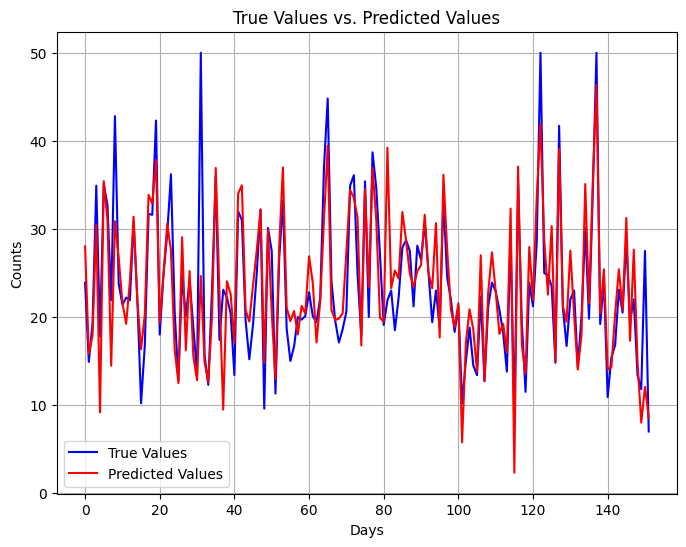

Root Mean Squared Error (RMSE): 4.589198612166833
Thetas:  [22.17529248 -1.08615792  1.01697847  0.22103061  0.91948097 -2.31603878
  2.98731672  0.15642278 -3.04819587  2.486479   -1.99276699 -2.04468701
  0.73034724 -3.67129697]


In [38]:
# Closed form solution 
# Regularization = True

lr = Linear_Regression(X, y, max_iteration=50, epsilon=0.003, learning_rate=0.001, lambda_ = 0.01,
                      sgd = False, 
                      gd = False, 
                      regularization=True)
lr.fit()


In [8]:
# # Closed form solution 
# Regularization = False

# lr = Linear_Regression(X, y, max_iteration=50, epsilon=0.003, learning_rate=0.001, lambda_ = 0.01,
#                       sgd = False, 
#                       gd = False, 
#                       regularization=False)
# lr.fit()

In [9]:
# # Gradient Descent 
# # Regularization = lasso
# warnings.filterwarnings('ignore')

# lr = Linear_Regression(X, y, max_iteration=1500, epsilon=0.03, learning_rate=0.00001, lambda_ = 0.01,
#                       sgd = False, 
#                       gd = True, 
#                       regularization='lasso')
# lr.fit()

In [10]:
# # Gradient Descent 
# # Regularization = ridge
# warnings.filterwarnings('ignore')

# lr = Linear_Regression(X, y, max_iteration=1500, epsilon=0.03, learning_rate=0.00001, lambda_ = 0.01,
#                       sgd = False, 
#                       gd = True, 
#                       regularization='ridge')
# lr.fit()

In [11]:
# Gradient Descent 
# Regularization = Fasle
# warnings.filterwarnings('ignore')

# lr = Linear_Regression(X, y, max_iteration=1500, epsilon=0.03, learning_rate=0.00001, lambda_ = 0.01,
#                       sgd = False, 
#                       gd = True, 
#                       regularization=False)

# lr.fit()

In [12]:
# Stocastic Gradient Descent 
# Regularization = True
# warnings.filterwarnings('ignore')

# lr = Linear_Regression(X, y, max_iteration=1500, epsilon=0.03, learning_rate=0.00001, lambda_ = 0.01,
#                       batch_size=0.3,
#                       sgd = True, 
#                       gd = False, 
#                       regularization=True)

# lr.fit()

In [13]:
# Stocastic Gradient Descent 
# Regularization = False
# warnings.filterwarnings('ignore')

# lr = Linear_Regression(X, y, max_iteration=1500, epsilon=0.03, learning_rate=0.00001, lambda_ = 0.01,
#                       batch_size=0.3,
#                       sgd = True, 
#                       gd = False, 
#                       regularization=False)

# lr.fit()